In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import sys
from collections import Counter
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing
from multiprocessing import Pool
import itertools
from copy import deepcopy

from datetime import datetime
import scipy.stats as stats
import os
import sklearn.metrics

In [2]:
tables = [pq.read_table('data/train_image_data_{0}.parquet'.format(i)) for i in range(4)]
tables = [table.to_pandas() for table in tables]
df = pd.concat(tables)
df = df.set_index("image_id")
del tables

In [48]:
def upper(img):
    up=0
    bottom=img.shape[0]
    while bottom-up>2:
        mid=(up+bottom)//2
        if np.sum(img[up:mid,:])==0:
            up=mid
        else:
            bottom=mid
    return up

def lower(img):
    up=0
    bottom=img.shape[0]
    while bottom-up>2:
        mid=(up+bottom)//2
        if np.sum(img[mid:bottom,:])==0:
            bottom=mid
        else:
            up=mid
    return bottom

def lefter(img):
    left=0
    right=img.shape[1]
    while right-left>2:
        mid=(left+right)//2
        if np.sum(img[:,left:mid])==0:
            left=mid
        else:
            right=mid
    return left

def righter(img):
    left=0
    right=img.shape[1]
    while right-left>2:
        mid=(left+right)//2
        if np.sum(img[:,mid:right])==0:
            right=mid
        else:
            left=mid
    return right

In [3]:
X=df.values.reshape(-1,137,236)

In [25]:
img=X[1]
ret2, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
img = 255-img

In [34]:
np.sum(img[0:5,:])

0

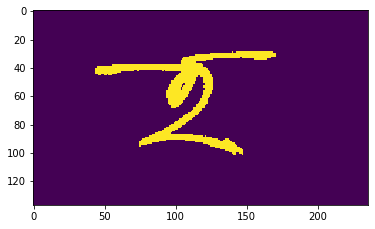

In [50]:
plt.imshow(img)

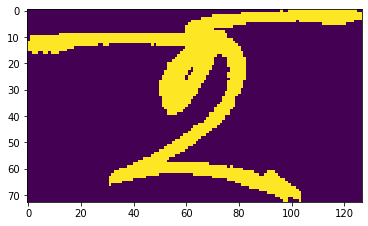

In [49]:
plt.imshow(img[upper(img):lower(img),lefter(img):righter(img)])

In [ ]:
size=(137,137)

def calcRotate(img):
    detector = cv2.ORB_create()
    keypoints=detector.detect(img)
    descriptors=detector.compute(img,keypoints)
    angles=[]
    weights=[]
    for i in descriptors[0]:
        if i.angle!=-1:
            angles.append(i.angle)
            weights.append(i.response)
    if len(angles)==0:
        return 0
    else:
        return np.average(angles,weights=weights)

def transformImg(img):
    ret2, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    img=255-img
    mu = cv2.moments(img, False)
    x, y= mu["m10"]/mu["m00"] , mu["m01"]/mu["m00"]
    M = np.float32([[1,0,(236/2)-x],[0,1,(137/2)-y]])
    img = cv2.warpAffine(img,M,(img.shape[1],img.shape[0]))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    kernel = np.ones((5,5),np.float32)/25
    img = cv2.filter2D(img,-1,kernel)
    img = cv2.filter2D(img,-1,kernel)
    angle = calcRotate(img)
    trans = cv2.getRotationMatrix2D((236/2,137/2), -1*angle , 1.0)
    img = cv2.warpAffine(img, trans, (img.shape[1],img.shape[0]))
    img = cv2.resize(img, (size[0],size[1]))
    #img = preprocess_input(img)
    return img

In [ ]:
img=X[0]
img=transformImg(img)

In [ ]:
img=X[12]
img=transformImg(img)
plt.imshow(img)